In [63]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))


True
12.1
NVIDIA GeForce RTX 4060 Laptop GPU


In [64]:
import mne
import numpy as np

import os

import matplotlib.pyplot as plt

from sklearn.utils import resample

In [65]:
directory = './eeg-during-mental-arithmetic-tasks-1.0.0/'

rest_filepaths = []
task_filepaths = []

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if filename.endswith('.edf'):
        label = filename.split('_')[-1].split('.')[0]

        if label == '1':
            rest_filepaths.append(filepath)
        else:
            task_filepaths.append(filepath)

In [66]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split

# Example function to read and process data
def process_data(filepath):
    data = mne.io.read_raw_edf(filepath, preload=True)
    data.set_eeg_reference()
    data.filter(l_freq=0.5, h_freq=45)
    
    min_t, max_t = 0, 61.99
    data.crop(tmin=min_t, tmax=max_t)
    
    tmin, tmax = 0, 1.0  # Epoch duration of 1 second
    epochs = mne.make_fixed_length_epochs(data, duration=tmax, preload=True)
    
    return epochs

# Function to process all 'task' labeled files
def process_task_files(filepaths):
    epochs_data = []  # List to store epoch data
    labels = []  # List to store corresponding labels
    
    for filepath in filepaths:
        epochs = process_data(filepath)
        epochs_data.extend(epochs.get_data())
        labels.extend([1] * len(epochs))  # Assign label 1 for 'task' (assuming 'task' label)
    
    return np.array(epochs_data), np.array(labels)

def process_rest_files(filepaths):
    epochs_data = []  # List to store epoch data
    labels = []  # List to store corresponding labels
    
    for filepath in filepaths:
        epochs = process_data(filepath)
        epochs_data.extend(epochs.get_data())
        labels.extend([0] * len(epochs))  # Assign label 1 for 'task' (assuming 'task' label)
    
    return np.array(epochs_data), np.array(labels)


In [67]:
%%capture
rest_epochs_data, rest_labels = process_rest_files(rest_filepaths)

task_epochs_data, task_labels = process_task_files(task_filepaths)

In [68]:
rest_epochs_data.shape, task_epochs_data.shape

((2196, 21, 500), (2196, 21, 500))

In [69]:
rest_labels.shape , task_labels.shape

((2196,), (2196,))

In [70]:
epochs_data_combined = np.concatenate([rest_epochs_data, task_epochs_data], axis=0)

# Concatenate labels
labels_combined = np.concatenate([rest_labels, task_labels], axis=0)

# Shuffle (optional)
# Use the same random seed for synchronizing shuffle across data and labels
random_state = 42
np.random.seed(random_state)
shuffle_indices = np.random.permutation(len(labels_combined))
data = epochs_data_combined[shuffle_indices]
label = labels_combined[shuffle_indices]

In [71]:
data.shape, label.shape

((4392, 21, 500), (4392,))

In [72]:
np.save('data.npy', data)
np.save('label.npy', label)

In [73]:
data = np.load('data.npy')
label = np.load('label.npy')

# # Convert numpy arrays to PyTorch tensors
# data = torch.tensor(data, dtype=torch.float32)
# label = torch.tensor(label, dtype=torch.long)  # Assuming labels are integers (dtype=torch.long)

# Print shapes to verify
print("Epochs tensor shape:", data.shape)
print("Labels tensor shape:", label.shape)

Epochs tensor shape: (4392, 21, 500)
Labels tensor shape: (4392,)


In [74]:
label.sum()

np.int64(2196)

In [75]:
# if isinstance(data, np.ndarray):
#     data = data[:, np.newaxis, :, :]
# else:
#     data = data.unsqueeze(1).permute(0, 1, 3, 2)

print(data.shape)

(4392, 21, 500)


In [76]:
from sklearn.model_selection import train_test_split


X_train , temp_data, y_train , temp_labels = train_test_split(data, label, test_size=0.3, random_state=42)
X_val , X_test , y_val , y_test  = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)


### Model


In [77]:
import mne
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler

# Scikit-Learn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

In [78]:
# Choosing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# # Normalizing Labels to [0, 1, 2, 3]
# y = labels - np.min(labels)
y = label

# Normalizing Input features: z-score(mean=0, std=1)
X = (data - np.mean(data)) / np.std(data)

# Checking the existance of null & inf in the dataset
if np.any(np.isnan(X)) or np.any(np.isinf(X)):
    raise ValueError("Data contains NaNs or infinities after normalization.")
if np.any(np.isnan(y)) or np.any(np.isinf(y)):
    raise ValueError("Labels contain NaNs or infinities.")

# Making the X,y tensors for K-Fold Cross Validation
X_tensor = torch.Tensor(X).unsqueeze(1)
y_tensor = torch.LongTensor(y)

# Spliting  Data: 80% for Train and 20% for Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Converting to Tensor
X_train = torch.Tensor(X_train).unsqueeze(1).to(device)
X_test = torch.Tensor(X_test).unsqueeze(1).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Creating Tensor Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Printing the sizes
print("Size of X_train:", X_train.size())
print("Size of X_test:", X_test.size())
print("Size of y_train:", y_train.size())
print("Size of y_test:", y_test.size())


Size of X_train: torch.Size([3513, 1, 21, 500])
Size of X_test: torch.Size([879, 1, 21, 500])
Size of y_train: torch.Size([3513])
Size of y_test: torch.Size([879])


In [79]:
class EEGNet(nn.Module): # EEGNET-8,2
    def __init__(self,  chans=21, classes=2, time_points=500, f1=64, f2=16, d=2,
                 dropoutRate=0.5, max_norm1=1, max_norm2=0.25):
        super(EEGNet, self).__init__()
        # Calculating FC input features
        linear_input_size = (time_points//32)*f2

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, 32), padding='same', bias=False),
            nn.BatchNorm2d(f1),
            # nn.BatchNorm2d(f1, momentum=0.01, eps=1e-3),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False), # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16),  groups=f2, bias=False, padding='same'), # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False), # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(linear_input_size, classes)

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

        # Apply max_norm constraint to the linear layer
        self._apply_max_norm(self.fc, max_norm2)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [80]:
input_size = (1, 21, 500) 
eegnet_model = EEGNet().to(device)
summary(eegnet_model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 21, 500]           2,048
       BatchNorm2d-2          [-1, 64, 21, 500]             128
            Conv2d-3          [-1, 128, 1, 500]           2,688
       BatchNorm2d-4          [-1, 128, 1, 500]             256
               ELU-5          [-1, 128, 1, 500]               0
         AvgPool2d-6          [-1, 128, 1, 125]               0
           Dropout-7          [-1, 128, 1, 125]               0
            Conv2d-8           [-1, 16, 1, 125]           2,048
            Conv2d-9           [-1, 16, 1, 125]             256
      BatchNorm2d-10           [-1, 16, 1, 125]              32
              ELU-11           [-1, 16, 1, 125]               0
        AvgPool2d-12            [-1, 16, 1, 15]               0
          Dropout-13            [-1, 16, 1, 15]               0
          Flatten-14                  [

In [81]:
eegnet_model = EEGNet().to(device)
learning_rate = 0.001
optimizer = optim.Adam(eegnet_model.parameters(), lr=learning_rate)

# Loss Function
criterion = nn.CrossEntropyLoss()

num_epochs = 500
batch_size = 512
for epoch in range(num_epochs):
    eegnet_model.train()
    X_train, y_train = shuffle(X_train, y_train)
    running_loss = 0.0
    correct = 0
    total = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs = eegnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(X_train)
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%")
average_loss = running_loss / len(X_train)
print("Average Loss:", average_loss)

# Saving model
torch.save(eegnet_model, 'eegnet_model.pth')

Epoch 1/500, Loss: 0.6975, Accuracy: 51.55%
Epoch 2/500, Loss: 0.6916, Accuracy: 52.92%
Epoch 3/500, Loss: 0.6883, Accuracy: 54.63%
Epoch 4/500, Loss: 0.6822, Accuracy: 56.96%
Epoch 5/500, Loss: 0.6786, Accuracy: 58.04%
Epoch 6/500, Loss: 0.6672, Accuracy: 60.20%
Epoch 7/500, Loss: 0.6573, Accuracy: 61.97%
Epoch 8/500, Loss: 0.6499, Accuracy: 63.08%
Epoch 9/500, Loss: 0.6437, Accuracy: 63.73%
Epoch 10/500, Loss: 0.6301, Accuracy: 65.13%
Epoch 11/500, Loss: 0.6202, Accuracy: 66.58%
Epoch 12/500, Loss: 0.6114, Accuracy: 67.52%
Epoch 13/500, Loss: 0.6034, Accuracy: 67.55%
Epoch 14/500, Loss: 0.5954, Accuracy: 68.46%
Epoch 15/500, Loss: 0.5830, Accuracy: 70.08%
Epoch 16/500, Loss: 0.5873, Accuracy: 68.86%
Epoch 17/500, Loss: 0.5608, Accuracy: 72.25%
Epoch 18/500, Loss: 0.5548, Accuracy: 72.33%
Epoch 19/500, Loss: 0.5528, Accuracy: 71.90%
Epoch 20/500, Loss: 0.5393, Accuracy: 72.50%
Epoch 21/500, Loss: 0.5414, Accuracy: 72.16%
Epoch 22/500, Loss: 0.5389, Accuracy: 72.16%
Epoch 23/500, Loss:

In [82]:

eegnet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(X_test)):
        inputs = X_test[i:i+1].to(device)
        labels = y_test[i:i+1].to(device)
        outputs = eegnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = (correct / total)*100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 92.04%


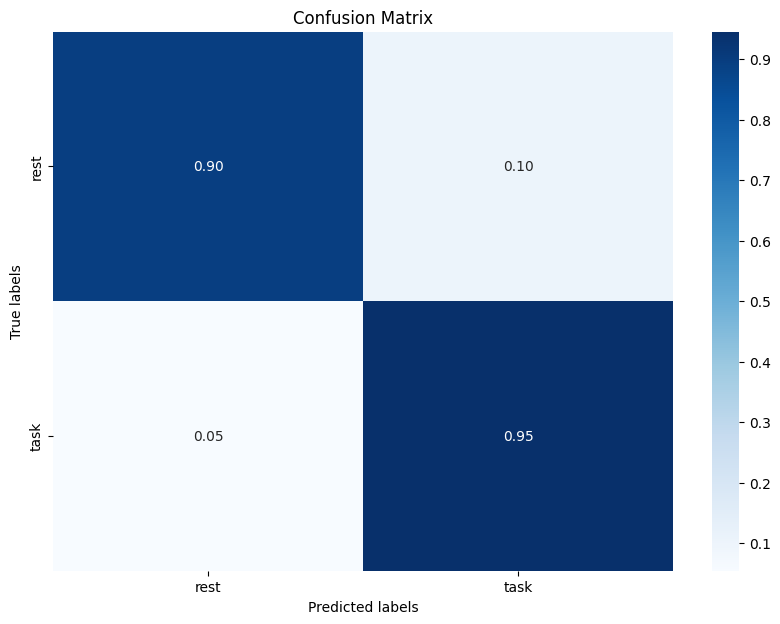

In [83]:
eegnet_model.eval()
y_pred = []
y_true = []
classes = ['rest', 'task']

with torch.no_grad():
    for inputs, labels in zip(X_test, y_test):
        outputs = eegnet_model(inputs.unsqueeze(0))  # Forward pass
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted.item())
        y_true.append(labels.item())

cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Create DataFrame for visualization
df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_eegnet.png')
plt.show()
